Logistic Regression

In [200]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,recall_score,roc_curve, roc_auc_score)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [201]:
y_test = pd.read_csv("../data/y_test.csv").values.ravel()
X_train_smote = pd.read_csv("../data/X_train_smote.csv")
y_train_smote = pd.read_csv("../data/y_train_smote.csv").values.ravel()
X_test_processed = pd.read_csv("../data/X_test_processed.csv")

In [202]:
leaky_features = ['max_delay', 'avg_delay', 'num_bad_months', 'months_total']
X_train_smote_clean = X_train_smote.drop(columns=leaky_features, errors='ignore')
X_test_processed_clean = X_test_processed.drop(columns=leaky_features, errors='ignore')

In [203]:
X_train_scaled = scaler.fit_transform(X_train_smote_clean) 
X_test_scaled = scaler.transform(X_test_processed_clean) 
model = LogisticRegression(max_iter=1000, class_weight='balanced') 
model.fit(X_train_scaled, y_train_smote) 
y_pred = model.predict(X_test_scaled)

In [204]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.523
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.52      0.68      5884
           1       0.02      0.49      0.04       116

    accuracy                           0.52      6000
   macro avg       0.50      0.51      0.36      6000
weighted avg       0.96      0.52      0.67      6000

Confusion Matrix:
[[3084 2800]
 [  59   57]]


ROC AUC Score: 0.553


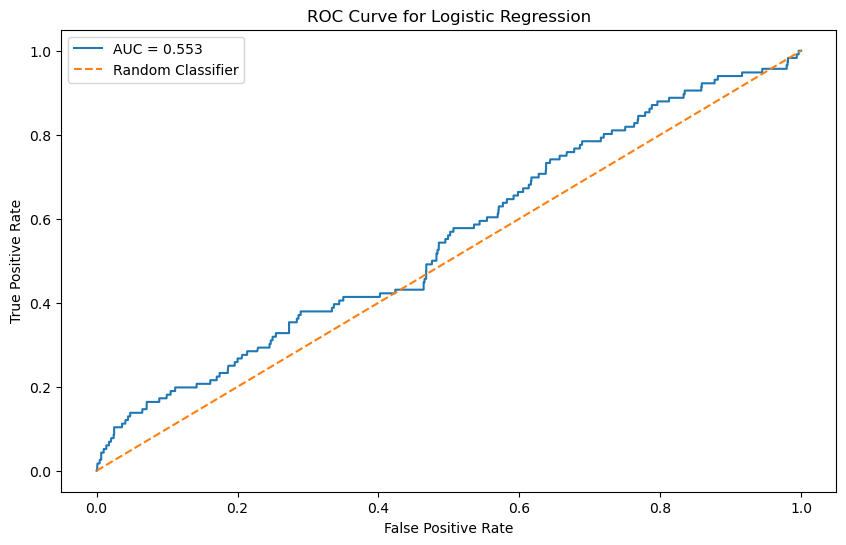

In [207]:
y_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {auc_score:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.show()


In [208]:
param_grid = {'C': [0.01, 0.1, 1, 10],'max_iter': [100, 200, 300, 400, 500]}
thresholds = np.arange(0.1, 1.0, 0.05)

best_recall_class1 = 0
best_params = {}
best_threshold = 0

for C in param_grid['C']:
    for max_iter in param_grid['max_iter']:
        model = LogisticRegression(C=C,max_iter=max_iter,class_weight='balanced')
        model.fit(X_train_scaled, y_train_smote)

        y_proba = model.predict_proba(X_test_scaled)[:, 1]

        for t in thresholds:
            y_pred = (y_proba >= t).astype(int)

            recall_0 = recall_score(y_test, y_pred, pos_label=0)
            recall_1 = recall_score(y_test, y_pred, pos_label=1) 

            #Only consider models where Recall of Class 0 >= 0.6
            if recall_0 >= 0.6 and recall_1 > best_recall_class1:
                best_recall_class1 = recall_1
                best_params = {"C": C, "max_iter": max_iter}
                best_threshold = t

print(f"Best Parameters: {best_params}")
print(f"Best Threshold: {best_threshold}")
print(f"Best Recall for Class 1: {best_recall_class1}")

tuned_model = LogisticRegression(C=best_params['C'],max_iter=best_params['max_iter'],class_weight='balanced')
tuned_model.fit(X_train_scaled, y_train_smote)

y_proba_tuned = tuned_model.predict_proba(X_test_scaled)[:, 1]
y_pred_tuned = (y_proba_tuned >= best_threshold).astype(int)

print("Classification Report when Class 0 recall >= 0.6")
print(classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))


Best Parameters: {'C': 0.1, 'max_iter': 100}
Best Threshold: 0.5500000000000002
Best Recall for Class 1: 0.35344827586206895
Classification Report when Class 0 recall >= 0.6
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      5884
           1       0.02      0.35      0.05       116

    accuracy                           0.71      6000
   macro avg       0.50      0.54      0.44      6000
weighted avg       0.96      0.71      0.82      6000

Confusion Matrix:
[[4240 1644]
 [  75   41]]


ROC AUC Score: 0.553


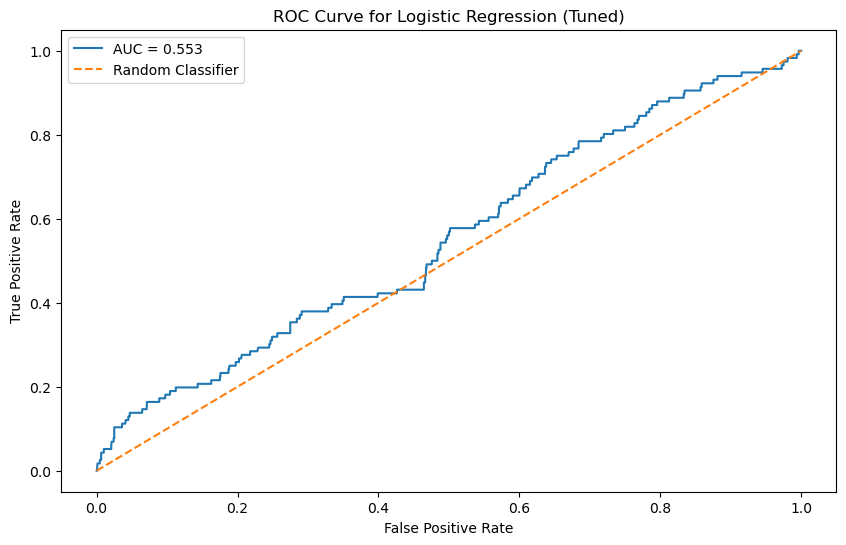

In [209]:
fpr, tpr, _ = roc_curve(y_test, y_proba_tuned)
auc_score = roc_auc_score(y_test, y_proba_tuned)

print(f"ROC AUC Score: {auc_score:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression (Tuned)')
plt.legend()
plt.show()

